# Computing wind shear from forecast fields and plotting it on a vertical cross section (GRIB)

In this example we will compute the vertical wind shear of horizontal wind speed from forecast fields stored in GRIB format and generate a vertical cross section out of it. 

In [1]:
import metview as mv

File *forecast_ml.grib* contains ECMWF forecast fields (step=+24h) on model levels retrieved from the MARS archive. We read this data into a [Fieldset](https://confluence.ecmwf.int/display/METV/Fieldset+Functions) which is Metview's own class to handle GRIB data.

In [2]:
fs = mv.read(source="./forecast_ml.grib")

Our dataset contains the following set of parameters:

In [3]:
set(fs.grib_get_string("shortName"))

{'lnsp', 'q', 't', 'u', 'v', 'z'}

Since geopotential is not archived on model levels in MARS our field *z* only contains the surface geopotential, which is - for technical reasons - stored on model level 1.

In [4]:
mv.read(data=fs,param="z").grib_get_string("levelist")

'1'

In this example we define the wind shear by dividing the wind speed difference with the distance of two adjacent model levels. Since we have neither wind speed nor geopotential in our dataset we need to compute both. 

First, we compute the wind speed.

In [5]:
u = mv.read(data = fs, param = "u")
v = mv.read(data = fs, param = "v")
sp = mv.sqrt(u*u + v*v)

Next, we use Metview's *mvl_geopotential_on_ml* function to compute the geopotential on model levels. This will perform a hydrostatic vertical integration in each gridpoint. 

In [6]:
t = mv.read(data = fs, param = "t")
q = mv.read(data = fs, param = "q")
zs = mv.read(data = fs, param = "z")
lnsp = mv.read(data = fs, param = "lnsp")

z = mv.mvl_geopotential_on_ml(t, q, lnsp, zs) 

Finally, the actual windshear computation can be done in a single line using Metview's high level fieldset operations. Here we made use of the fact that our fieldsets are sorted by level in ascending order (and we have 137 model levels in total).

In [7]:
shear = (sp[0:135] - sp[1:136]) / (z[0:135] - z[1:136])

We convert the result into *m/s/km* units for easier interpretation and plotting.

In [8]:
shear = shear * 9.81 * 1000 

To plot our data, we need to tell Metview to send the graphical output to Jupyter.

In [9]:
mv.setoutput('jupyter')

Plotting is performed through Metview's interface to the [Magics](https://confluence.ecmwf.int/display/MAGP/Magics) library developed at ECMWF. 

We will first define the cross section line and plot it onto a map together with the wind speed on model level 80 (~250 hPa) to make sure that the cross section will go through an interesting weather feature, the jet stream, in our case. 

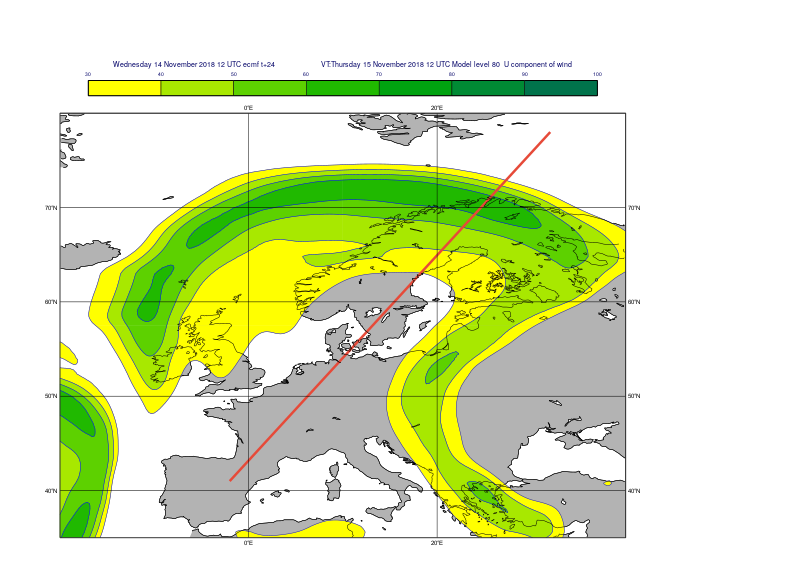

In [10]:
area_view = mv.geoview(
    map_area_definition = 'corners',
    area = [35,-20,80,40],
    coastlines = mv.mcoast(
        map_coastline_land_shade        = "on",
        map_coastline_land_shade_colour = "grey"
    )
)

line = [41,-2,78,32]

line_graph = mv.mgraph(
    graph_type         = "curve",
    graph_line_colour  = "coral",
    graph_line_thickness = 5
)

speed_cont = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_grn_f30t100i10")

mv.plot(area_view,
        mv.read(data = sp, levelist = 80),speed_cont,
        mv.mvl_geoline(*line,1),line_graph)

In the cross section we will overlay the computed wind shear with the wind speed and also want to plot the orography along the section line. First, we define a cross section view  with logarithmic vertical coordinates in pressure between 1015 and 80 hPa. 

In [11]:
xs_view = mv.mxsectview(
  line = line,
  top_level = 80,
  vertical_scaling = "log"
)

Next, we define the contouring for the wind shear and wind speed, respectively. For the wind shear, being the main feature, we use isoline shading while the wind speed is simply plotted with dashed isolines. We also specify area filling to represent the orography.

In [12]:
sh_cont= mv.mcont(
    legend                     = "on",
    contour_line_colour        = "charcoal",
    contour_highlight           = "off",    
    contour_max_level           = 40,
    contour_min_level           = -40,
    contour_level_count         = 21,
    contour_label               = "off",
    contour_shade               = "on",
    contour_shade_method        = "area_fill",
    contour_shade_colour_method = "palette",
    contour_shade_palette_name  = "eccharts_black_red_21"
)

sp_cont = mv.mcont(
    contour_line_style     = "dash",
    contour_line_thickness = 2,
    contour_line_colour    = "charcoal",
    contour_highlight      = "off",
    contour_min_level      = 20
)

orog_graph = mv.mgraph(
    graph_type         = "area",
    graph_shade_colour  = "charcoal"
)

The final step is to define the input datasets and pass them on to the cross section. Since our data is available on model levels and we want to use a pressure-based cross section we need to supply the *lnsp* filed (logarithm of surface pressure) so that Metview could perform the required vertical interpolation. The *lnsp* field is also required for plotting the orography. 

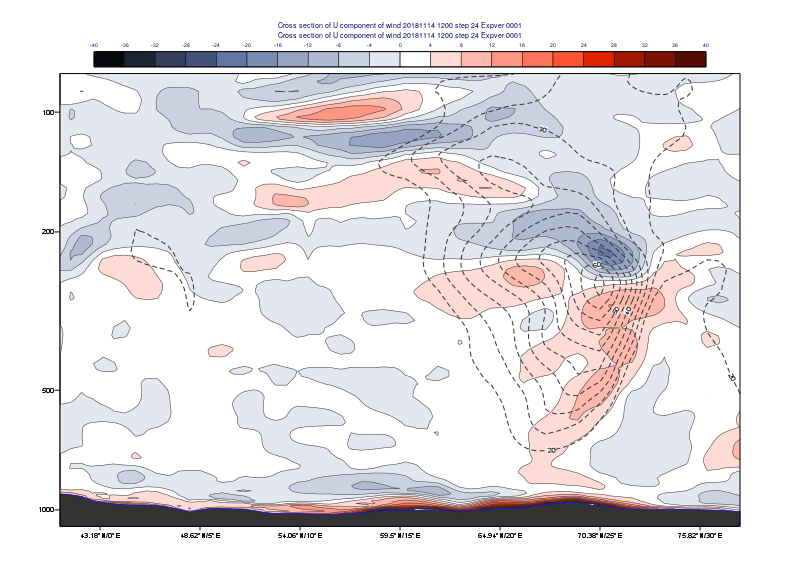

In [13]:
xs_sh_data = mv.merge(shear,lnsp)
xs_sp_data = mv.merge(sp,lnsp)

mv.plot(xs_view,
        xs_sh_data,sh_cont,
        xs_sp_data,sp_cont,
        orog_graph)

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)